__Pipline__: 
- Camera calibration + Distortion
- Get binary image (Gradients and color spaces)
- Perspective
- Find lines (Sliding windows):
    - First search
    - Use previous data in following searches
    - Sanity Check and define pipeline
    

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

In [2]:
def show2img(img1,img2,title1='Image 1',title2='Image 2',save = False, save_title = "no_title"):
    """ Visualize 2 images in a row"""
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=30)
    if save:
        if save_title == 'no_title':
            save_title = title1+'_'+title2
        plt.savefig('output_images/'+save_title+'.jpg', bbox_inches='tight')

## 1.- Camera Calibration

In [3]:
CAL_IN_PATH = 'camera_cal/'
CAL_OUT_PATH = 'camera_cal_output/'
CAL_DATA_PATH = 'calibration_data/'

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9 # Corners x
ny = 6 # Corners y
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # only x, y coordinates

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(CAL_IN_PATH + 'calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)    # Add points from distorisioned image (same for every picture)
        imgpoints.append(corners) # Add real points.

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(CAL_OUT_PATH + write_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()

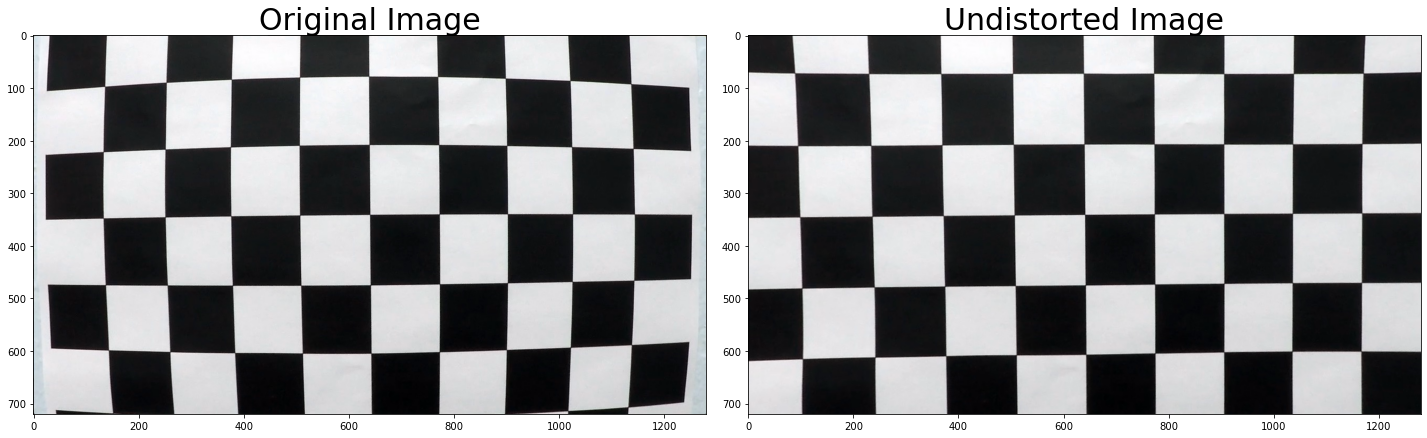

In [6]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread(CAL_IN_PATH + 'test_cal.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# dist = distortion ciefficents
# mtx = distortion matrix

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(CAL_OUT_PATH + 'result_test_cal.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open(CAL_DATA_PATH + "/wide_dist_pickle.p", "wb" ) )

show2img(img,dst,'Original Image','Undistorted Image',save=True,save_title='Distortion')

## 2.- Get Binary Image

In [7]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ Applies Sobel x or y"""
   
    if len(img.shape) > 2: #if have more than 1 channel
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # image read with mpimg.imread() (if its read with cv2.imread() use COLOR_BGR2GRAY instead)
    else:
        gray = img
        
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        return img
    
    abs_sobel = np.absolute(sobel)  # Take the absolute value of the derivative or gradient
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """Applies Sobel x and y
    then computes the magnitude of the gradient and applies a threshold
    return the magnitude of the gradient for a given sobel kernel size and threshold values"""
    # Convert to grayscale
    if len(img.shape) > 2: #if have more than 1 channel
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # image read with mpimg.imread() (if its read with cv2.imread() use COLOR_BGR2GRAY instead)
    else:
        gray = img
        
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """applies Sobel x and y
    then computes the direction of the gradient and applies a threshold """
    # Grayscale
    if len(img.shape) > 2: #if have more than 1 channel
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # image read with mpimg.imread() (if its read with cv2.imread() use COLOR_BGR2GRAY instead)
    else:
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def channel_binary_select(b_image, thresh=(0, 255)):        
    binary_output = np.zeros_like(b_image)
    binary_output[(b_image > thresh[0]) & (b_image <= thresh[1])] = 1
    return binary_output

def get_binary(image):

    # Undistorted
    image = cv2.undistort(image, mtx, dist, None, mtx)

    # Apply Gaussian Blur
    image = gaussian_blur(image,3)
    s = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS).astype(np.float)[:, :, 2]
    
    # Mask s
    masked_s = np.zeros_like(s)
    masked_s[(s >= 170) & (s <= 255)] = 1

    # Apply yellow mask
    lower_yellow = np.array([20, 100, 100], dtype = "uint8")
    upper_yellow = np.array([30, 255, 255], dtype = "uint8")
    masked_yellow = cv2.inRange(image, lower_yellow, upper_yellow)

    # Apply white mask
    lower_white = np.array([180, 180, 180], dtype = "uint8")
    upper_white = np.array([255, 255, 255], dtype = "uint8")
    masked_white = cv2.inRange(image, lower_white, upper_white)

    # Mask rgb white/yellow
    masked_rgb=np.zeros_like(masked_white)
    masked_rgb[(masked_white>0) | (masked_yellow>0)]=1
    
    # Sobel in s
    ksize = 3
    gradx = abs_sobel_thresh(s, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(s, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    gradMag = mag_thresh(s, sobel_kernel=ksize, mag_thresh=(20, 100))
    gradDir = dir_threshold(s, sobel_kernel=ksize, thresh=(.7, 1.3))

    masked_grad = np.zeros_like(s)
    masked_grad[((gradx == 1) & (grady == 1)) | ((gradMag == 1) & (gradDir == 1))] = 1
    
    # Combine
    combined_binary = np.zeros_like(gradx)
    combined_binary[(masked_s>0) | (masked_rgb>0) | (masked_grad>0)] = 1
    return combined_binary

## 3.- Apply mask

In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_rec(img,vertices):
    """Plot mask created with 4 points"""
    lines = [0 for i in range(4)]
    for i in range(4):        
        if i < 3:
            i2 = i + 1  
        else:
            i2 = 0
        lines[i] = [vertices[i][0],vertices[i][1],vertices[i2][0],vertices[i2][1]]
    
    for line in lines:
        cv2.line(img, (line[0],line[1]), (line[2],line[3]), [255,0,0], 5)
    return

def apply_mask(image):
    imshape = image.shape
    downLeft = (160,imshape[0]-25)
    upLeft = (580, (imshape[0] /2)+70)
    upRight = (imshape[1]-580, (imshape[0] /2)+70)
    downRight = (imshape[1]-150,imshape[0]-25)
    vertices = np.array([[downLeft,upLeft, upRight, downRight]], dtype=np.int32)
    return region_of_interest(image, vertices)

In [9]:
# Define perspective trasnform function
def warp(image, plot_result = False):
    
    img = np.copy(image)
    M, Minv = get_perspective_mtx(img)
    
    # Create warped image - using linear interpolation
    warped = np.copy(img)
    warped = cv2.warpPerspective(warped, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Plot transformation
    if plot_result:
        src, dst = get_tranfomation_points(img)
        cv2.rectangle(img, np.int32(dst[0]),np.int32(dst[3]), [255,0,0], 5)
        fig = plt.figure()
        plt.imshow(img)
        for s in src:
            plt.plot(np.int32(s[0]),np.int32(s[1]),'bo')
            plt.savefig('output_images/transoform.jpg', bbox_inches='tight')

    return warped

def get_perspective_mtx(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    src, dst = get_tranfomation_points(img)
    img_size = (img.shape[1],img.shape[0])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M, Minv

def get_tranfomation_points(img):
    # Four source coordinates
    src = np.float32(
        [[557,475],
        [729,475],
        [291,665],
        [1030,665]])
    
    # Four desired coordinates
    img_height, img_width = img.shape[:2]
    # dst_height = np.rint(img_height) / 2
    dst_height = 0
    dst_width = np.rint(img_width) / 3
    dst = np.float32(
        [[dst_width,dst_height+5],
        [dst_width*2,dst_height+5],
        [dst_width,665],    # use source y
        [dst_width*2,665]]) # use source y
    return src, dst
    

## 5.- Detect lines

### 5.1.- Sliding Windows

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Initialize current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, plot_frame = False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    if((len(rightx) < 2) or (len(righty) < 2)):
        return 0, 0, 0, 0, 0
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    if plot_frame:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow',alpha=0.8)
        plt.plot(right_fitx, ploty, color='yellow',alpha=0.8)
        plt.imshow(out_img)
        plt.savefig('output_images/sliding_windows.jpg', bbox_inches='tight')
        
    return left_fit, right_fit, left_fitx, right_fitx, ploty

### 5.2.- Search from prior
Skip the sliding windows step once you've found the lines. Use margins from previous polynomials

In [11]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, plot_results = False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_line = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2]
    right_line = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = (nonzerox > (left_line - margin)) & (nonzerox < left_line + margin)
    right_lane_inds = (nonzerox > (right_line - margin)) & (nonzerox < (right_line + margin))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Visualization
    if(plot_results):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        # View your output
        plt.imshow(result)
        plt.savefig('output_images/search_arround.jpg', bbox_inches='tight')
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

## 6.- Measuring Curvature

In [12]:
def get_curvature(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    # xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + 
                           left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + 
                            right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad

def get_line_base_pos(ploty, left_fit, right_fit):
    
    # Define conversions in x and y from pixels space to meters
    # ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    img_width = 1280
    
    # Get x coordinate at the bottom of the image (in meters)
    y_eval = np.max(ploty)
    
    left_point_pix = left_fit[0]*(y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_point_pix = right_fit[0]*(y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    mid_point_pix = (img_width/2)
        
    diff_pix = mid_point_pix - np.mean([left_point_pix, right_point_pix])
    
    diff = diff_pix*xm_per_pix
    
    return diff
    

### 7.- Return to original image

In [13]:
def get_rectangle(img, left_fitx, right_fitx, ploty, plot_results = False):
    
    rec = np.zeros_like(img)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    line_pts = np.hstack((left_line, right_line))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(rec, np.int_([line_pts]), (255,255,255))

    lines = plot_lines(img, left_fitx, right_fitx, ploty)

    return rec, lines

def plot_lines(img, left_fitx, right_fitx, ploty):
    binary = np.zeros_like(img)

    # Recast the x and y points into usable format for cv2.fillPoly()
    l = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    r = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    # Draw the lines onto the warped blank image
    cv2.polylines(binary, np.int_([l]), isClosed=False, color=(255,0,0), thickness=20)
    cv2.polylines(binary, np.int_([r]), isClosed=False, color=(255,0,0), thickness=20)
    return binary

# 7.- Pipeline and Implementation

In [14]:
MAX_CORRUPTED_FRAMES = 2
original_img = mpimg.imread('test_images/test5.jpg')
M, Minv = get_perspective_mtx(original_img)
img_size = (original_img.shape[1],img.shape[0])
STRAIGHT_LINE_CURV = 4000


# USE fit_polynomial to find new line without previous information
# USE search_around_poly to find new line using previous line information

def process_frame(frame):
    original_frame = np.copy(frame)
    
    # Transform frame: convert binary, apply mask and apply perspective transform
    frame = get_binary(frame)    
    frame = apply_mask(frame)
    frame = warp(frame)
    
    # Get fit polynomial
    if process_frame.first_frame:
        # Get lines new lines (slide window)
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(frame) 
        
        # Get offset and curvature on frame
        left_curverad, right_curverad = get_curvature(ploty, left_fit, right_fit)
        curv = (left_curverad + right_curverad) / 2
        offset = get_line_base_pos(ploty, left_fit, right_fit)
                
        # Set variables
        process_frame.corrupted_frame = 0
        process_frame.acum_curv = 0 
        process_frame.mean_curv = 0 
        process_frame.count_curv = 0 
        process_frame.first_frame = False
    else:
        # Get lines with previous info
        left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(frame, process_frame.last_left_fit, process_frame.last_right_fit)
        
        # Get offset and curvature on frame
        left_curverad, right_curverad = get_curvature(ploty, left_fit, right_fit)
        curv = (left_curverad + right_curverad) / 2
        offset = get_line_base_pos(ploty, left_fit, right_fit)
        
        # If offset or curvature change mor than 20% => is not valid frame
        # if not (offset > process_frame.last_offset*1.20) | (offset < process_frame.last_offset*.8) | (curv > process_frame.last_curv*1.20) | (curv < process_frame.last_curv*.8):
        if not (offset > process_frame.last_offset*1.20) | (offset < process_frame.last_offset*.8):
            process_frame.corrupted_frame += 1
            if (process_frame.corrupted_frame >= MAX_CORRUPTED_FRAMES):
                # Get lines new lines (slide window)
                left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(frame)
                
                # Get offset and curvature on frame
                left_curverad, right_curverad = get_curvature(ploty, left_fit, right_fit)
                curv = (left_curverad + right_curverad) / 2
                offset = get_line_base_pos(ploty, left_fit, right_fit)
                
            else:
                # If cannot find => use previous frame info
                curv = process_frame.last_curv
                offset = process_frame.last_offset
                left_fit = process_frame.last_left_fit
                right_fit = process_frame.last_right_fit

                # Plot
                rec,lines = get_rectangle(frame, left_fitx, right_fitx, ploty)
                img_rec = np.dstack((lines, rec, rec))
                unwarped_rec = cv2.warpPerspective(img_rec, Minv, img_size, flags=cv2.INTER_LINEAR)

                frame = cv2.addWeighted(original_frame, 1, unwarped_rec, 0.3, 0)

                # Write offset and curvature on frame
                process_frame.acum_curv+= curv 
                process_frame.count_curv += 1 
                if process_frame.count_curv>=process_frame.fps/2:
                    process_frame.mean_curv = process_frame.acum_curv /process_frame.count_curv
                    process_frame.acum_curv = 0
                    process_frame.count_curv = 0

                # if process_frame.mean_curv>STRAIGHT_LINE_CURV:
                    # frame = cv2.putText(frame, 'Curvature: Straight Line', (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
                # else:
                #     frame = cv2.putText(frame, 'Curvature: {:.2f}m'.format(process_frame.mean_curv), (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
                    
                frame = cv2.putText(frame, 'Curvature: {:.2f}m'.format(process_frame.mean_curv), (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
                frame = cv2.putText(frame, 'Offset: {:.2f}m'.format(offset), (50, 120),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)  

                return frame
    
    if type(left_fit) == int or type(right_fit) == int or type(left_fitx) == int or type(right_fitx) == int :
        return original_img
    
    process_frame.corrupted_frame = 0 # found valid lines  

    # Store parameters
    process_frame.last_curv = curv
    process_frame.last_offset = offset
    process_frame.last_left_fit = left_fit
    process_frame.last_right_fit = right_fit
    
    # Plot
    rec,lines = get_rectangle(frame, left_fitx, right_fitx, ploty)
    img_rec = np.dstack((lines, rec, rec))
    unwarped_rec = cv2.warpPerspective(img_rec, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    frame = cv2.addWeighted(original_frame, 1, unwarped_rec, 0.3, 0)
    
    # Write offset and curvature on frame
    process_frame.acum_curv+= curv 
    process_frame.count_curv += 1 
    if process_frame.count_curv>=process_frame.fps/2:
        process_frame.mean_curv = process_frame.acum_curv /process_frame.count_curv
        process_frame.acum_curv = 0
        process_frame.count_curv = 0
    # if process_frame.mean_curv>STRAIGHT_LINE_CURV:
    #     frame = cv2.putText(frame, 'Curvature: Straight Line', (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
    # else:
    #     frame = cv2.putText(frame, 'Curvature: {:.2f}m'.format(process_frame.mean_curv), (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
    frame = cv2.putText(frame, 'Curvature: {:.2f}m'.format(process_frame.mean_curv), (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)
    frame = cv2.putText(frame, 'Offset: {:.2f}m'.format(offset), (50, 120),  cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 9, 127), 4, cv2.LINE_AA)    
    
    return frame


In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import Video

In [16]:
white_output = 'test_videos_output/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(30,35)
clip1 = VideoFileClip("project_video.mp4")
print("FPS: "+str(clip1.fps))
process_frame.first_frame = True
process_frame.fps = clip1.fps
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

FPS: 25.0


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 5min 14s


In [17]:
Video(white_output, width=400)